In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import math
import pickle

from fitter import Fitter, get_common_distributions, get_distributions

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('PS1C_train.csv')

In [3]:
data.drop(columns = ['Index'], inplace=True)
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C21,C22,C23,C24,C25,C26,C27,C28,C29,Target
0,-0.633509,-0.287744,0.222853,-2.998039,-0.690275,-0.674866,-0.404163,0.405966,-2.319937,0.775369,...,0.031281,0.395767,-0.097444,-0.357012,-0.230728,-0.239019,0.272303,0.128075,29.89,0
1,-1.432863,-1.290936,1.081047,1.689179,1.857100,-0.633250,-0.808269,0.466850,-0.099381,0.161682,...,0.233531,0.229839,0.367753,-0.345799,-0.614424,-0.322642,0.159902,0.221186,38.94,0
2,-1.275721,-0.939394,1.391180,-1.432628,-1.598677,0.829657,1.103927,-0.276995,0.600442,-0.757897,...,0.161042,0.918642,0.382627,-0.575711,0.240417,-0.217267,0.191545,-0.014056,399.40,0
3,2.117287,0.170442,-1.945039,0.273686,0.740743,-0.530378,0.199080,-0.220303,0.476406,-0.388658,...,-0.399412,-1.022962,0.261353,-0.051819,-0.165381,0.207375,-0.060959,-0.035671,1.79,0
4,2.196452,-1.362427,-0.280416,-1.437635,-1.381315,-0.249888,-1.454115,-0.136940,-0.081281,1.275863,...,-0.496381,-0.743399,0.391387,-0.437921,-0.595208,-0.528237,0.009113,-0.047769,39.95,0


C:\Users\91979\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


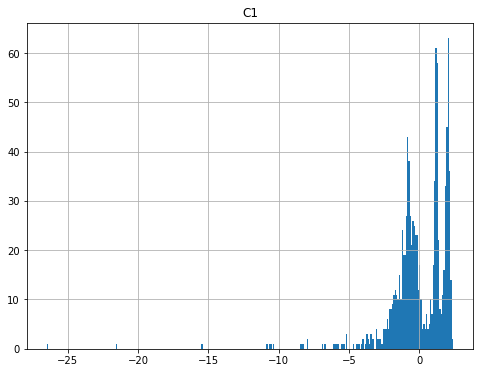

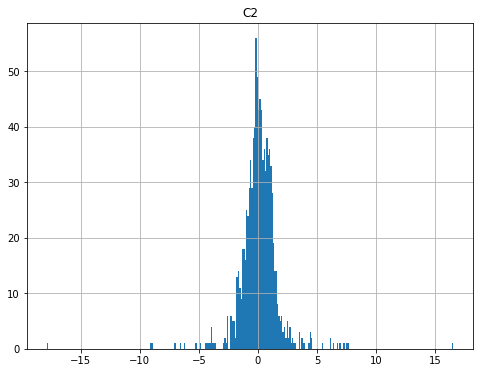

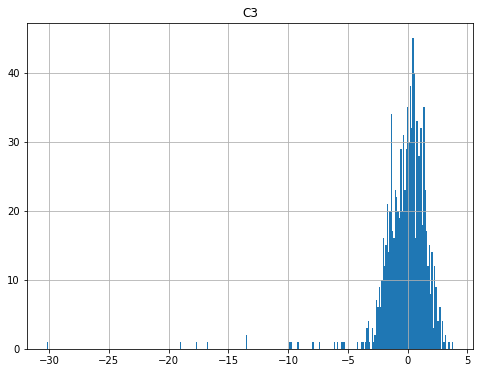

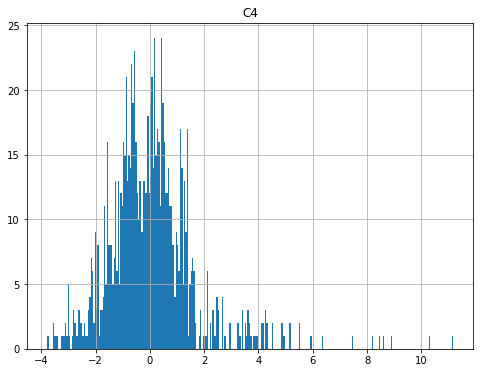

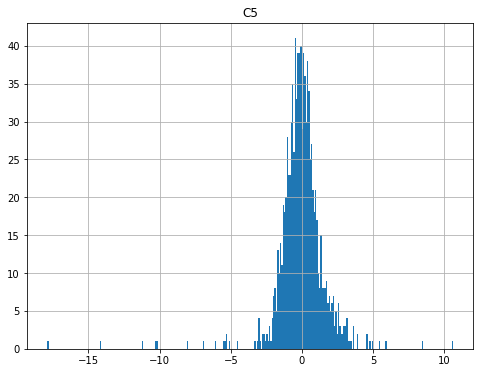

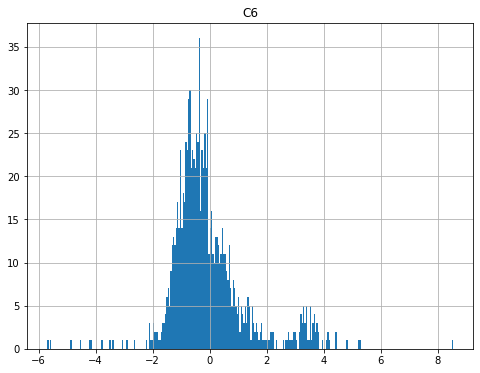

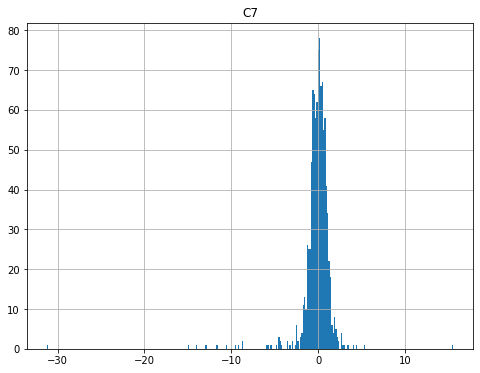

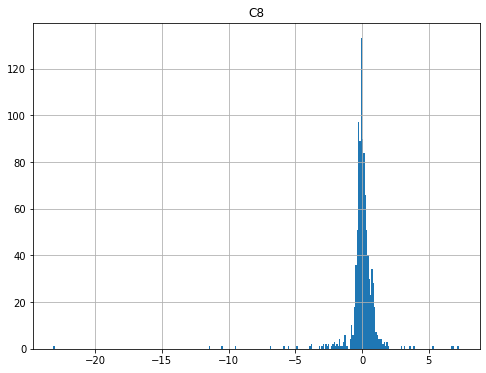

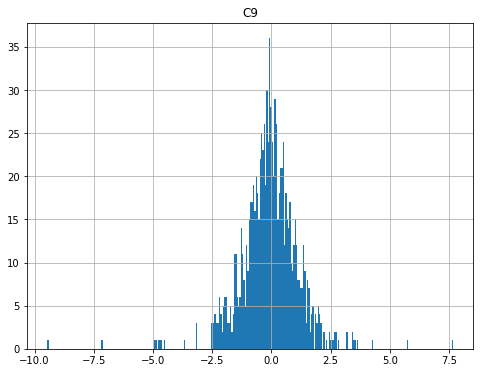

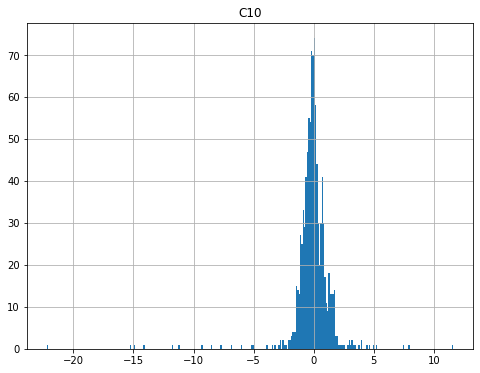

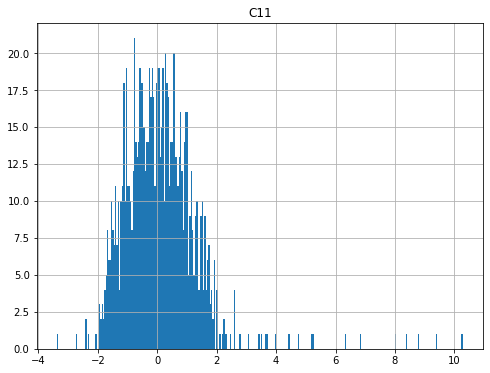

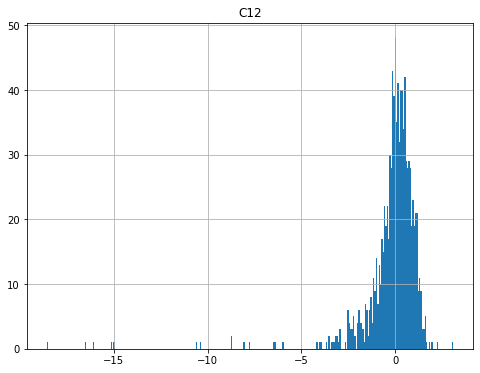

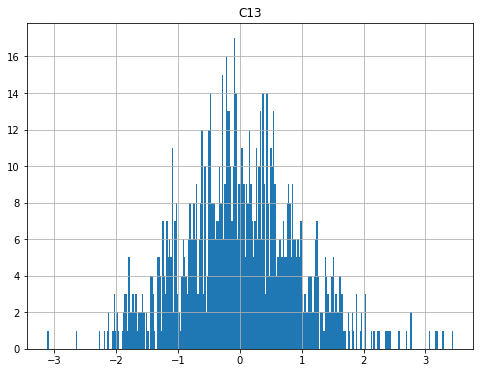

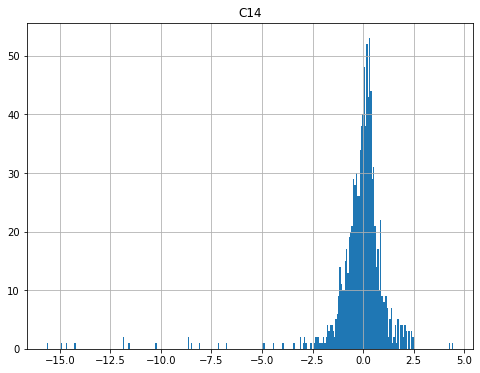

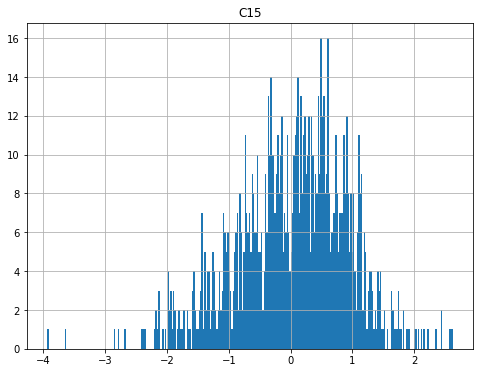

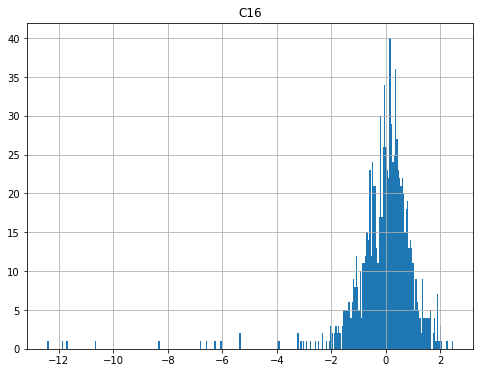

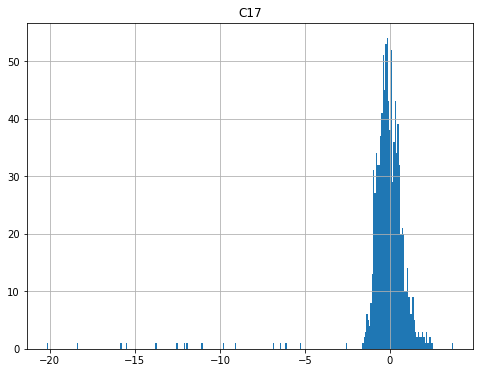

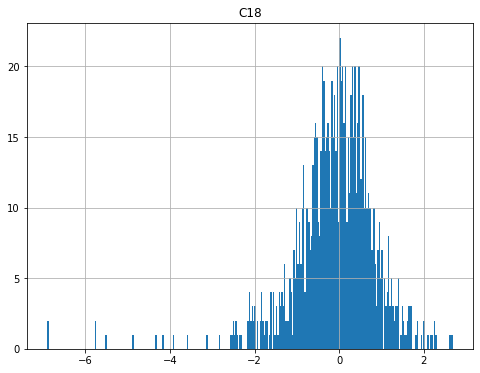

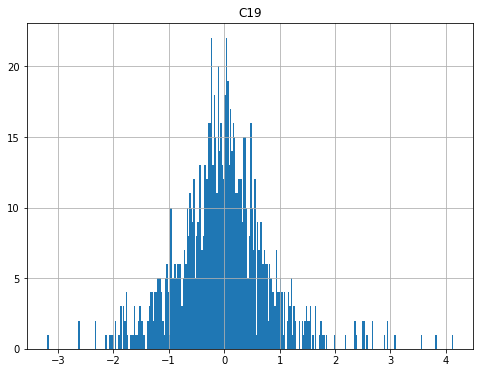

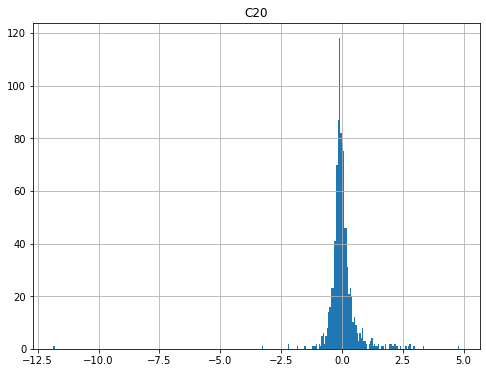

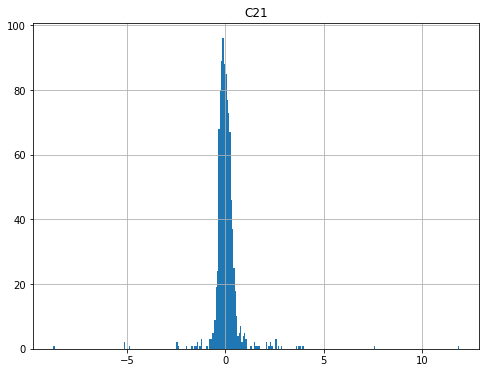

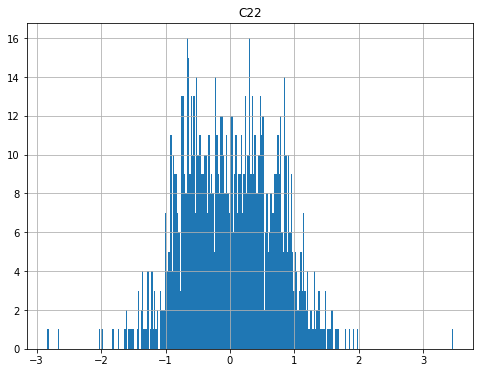

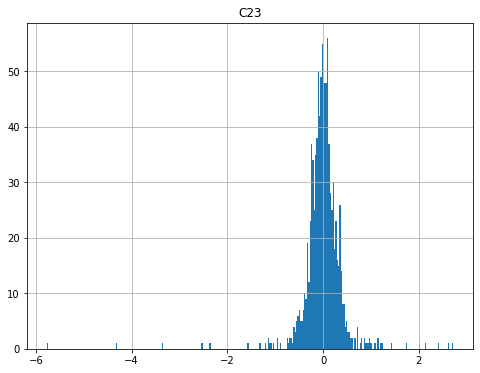

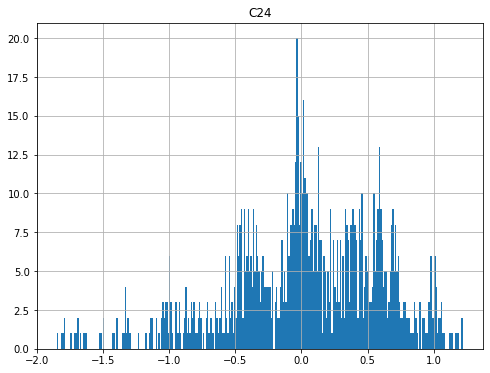

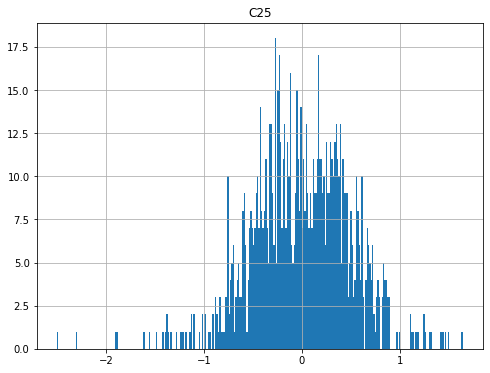

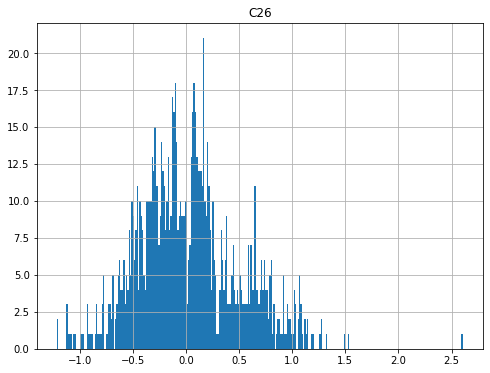

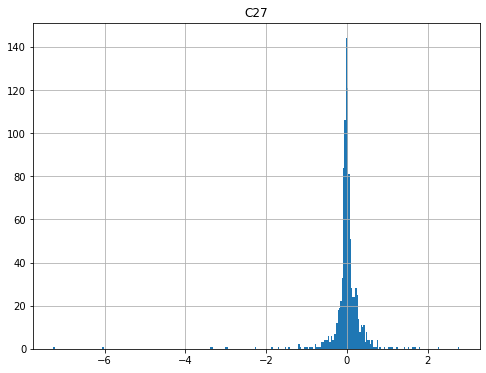

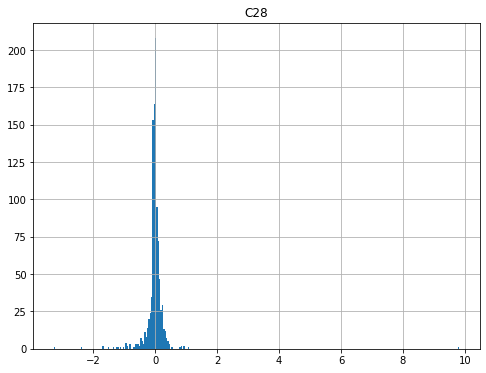

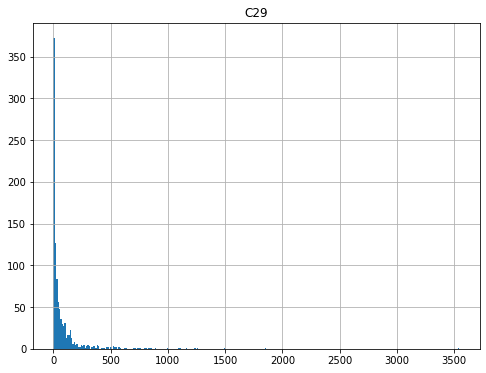

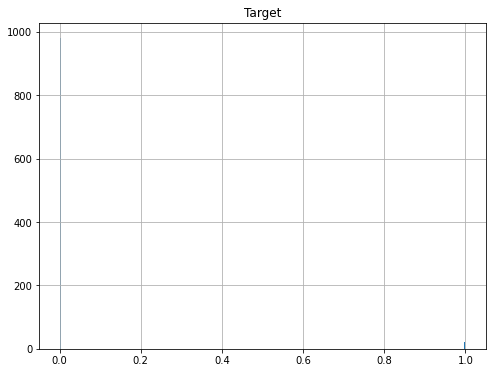

In [4]:
for i in list(data):
    data.hist(column=[i],bins=300, figsize=(8,6))

In [5]:
#sns.pairplot(data)

# New Approach

In [6]:
ndata = data.to_numpy()

# class separation & balancing

In [7]:
grouped = data.groupby('Target')

In [8]:
df_1 = grouped.get_group(1)
df_0 = grouped.get_group(0)

In [9]:
ndf_1 = df_1.to_numpy()
ndf_0 = df_0.to_numpy()

# model

In [10]:
def datagen(ndata, multiplier):
    l=[]

    for i in range((multiplier)*ndata.shape[0]):
        a = np.random.uniform(0,ndata.shape[0]-1,1)
        a = int(round(a[0],0))
        b = np.random.uniform(0,ndata.shape[0]-1,1)
        b = int(round(b[0],0))

        d = ndata[a] + np.random.uniform(0,1,1)*(ndata[b]-ndata[a])

        l.append(d)
    return np.array(l)

In [11]:
def balanced_gen(ndf_1,ndf_0,Total_size):
    a1 = datagen(ndf_1, int(0.5*Total_size/ndf_1.shape[0]))
    a0 = datagen(ndf_0, int(0.5*Total_size/ndf_0.shape[0]))
    
    #temp1 = np.append(ndf_1, a1, axis = 0)
    #temp2 = np.append(ndf_0, a0, axis = 0)
    up_data = np.append(a1, a0, axis = 0)
    
    up_df = pd.DataFrame(up_data)
    #up_df[8] = up_df[29].round(decimals = 0)
    up_df = up_df.astype({29: int})
    
    return(up_df.sample(frac = 1))

In [12]:
df_gen_temp = balanced_gen(ndf_1,ndf_0,5000)

In [13]:
df_gen_temp

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
2630,-1.239920,-0.302384,1.358103,0.182414,-0.314456,-0.191638,0.996017,0.057684,-0.947987,-0.516032,...,0.057564,-0.388285,0.420194,0.121796,0.129519,0.259907,-0.053523,0.044749,236.158250,0
2084,-3.324274,4.543113,-8.647730,6.795011,-2.887739,-2.033368,-6.351371,2.782150,-2.229307,-6.640263,...,0.953681,-0.076291,-0.084025,-0.439229,-0.479963,-0.058503,0.480949,-0.211850,22.396295,1
1022,-3.191942,2.537937,-2.986235,2.497158,-2.564776,-0.879315,-2.935729,0.439317,-1.578349,-3.611752,...,1.148555,0.353259,0.067467,0.087467,-0.008710,0.005751,-0.622733,-0.020374,107.529462,1
515,0.870099,2.076671,-3.618779,5.154336,0.402363,-1.021004,-1.327387,0.392952,-1.744866,-1.883206,...,0.076894,-0.529506,0.131312,-0.348117,-0.307913,-0.170034,0.090863,-0.085047,2.881846,1
1043,-1.021099,1.901608,-1.064808,3.470032,-1.427233,-0.069717,-2.789400,0.997106,-2.137618,-2.072510,...,0.866518,0.454814,-0.031211,-0.413911,-0.435814,0.124243,0.394157,0.094230,6.162243,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,-1.987101,2.681197,-0.322741,1.472658,-0.698105,1.421662,-3.286164,-6.008984,-1.453106,-1.607688,...,-3.058488,1.702171,0.497385,-0.210955,-0.574986,-0.213440,0.004541,0.188014,1.000000,0
3670,1.227536,0.635870,-0.250223,1.608347,0.363729,-0.569440,0.344663,-0.156443,-0.393465,-0.125957,...,-0.190935,-0.547187,-0.077887,-0.337926,0.595445,-0.292556,0.012700,0.035770,13.164632,0
215,1.345925,2.869077,-5.540040,5.299097,1.804398,-1.726847,-0.468396,0.141417,-2.857037,-3.149494,...,0.063162,-0.707200,-0.084802,-0.071949,0.386733,0.080746,0.371896,0.263316,0.504122,1
219,-14.684714,7.242448,-18.386359,10.890633,-6.524737,-2.092010,-14.253796,-0.703041,-6.954472,-13.607713,...,-2.349895,0.684646,-0.335021,-0.958342,0.969722,0.789259,2.168925,-1.127428,1.050381,1


In [14]:
df_gen_temp2 = df_gen_temp.drop(columns=[29])

In [15]:
df_gen_temp2.shape

(4460, 29)

In [16]:
#noise = np.random.normal(0, 0.5, [df_gen_temp2.shape[0],df_gen_temp2.shape[1]])

In [17]:
mean_value = df_gen_temp.mean()
mean = mean_value.to_numpy()
#print(df_gen.shape[1])
for i in range(0, df_gen_temp.shape[1]):
    noise = np.random.normal(0, np.absolute(mean[i]) , [df_gen_temp.shape[0], df_gen_temp.shape[1]-1])

In [18]:
noise.shape

(4460, 29)

In [19]:
df_gen_temp3 = pd.DataFrame(noise+df_gen_temp2)

In [20]:
df_gen_temp3[29] = df_gen_temp[29]

In [21]:
df_gen = df_gen_temp3.copy()

In [22]:
df_gen.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
2630,-1.442822,0.753903,0.998024,1.341806,0.378678,-1.202512,-0.309688,0.144398,-1.270786,-0.123321,...,0.208356,-0.168936,-0.012175,0.152576,0.324216,0.282647,0.877973,-0.101677,235.231395,0
2084,-2.389811,5.068798,-8.176449,6.998027,-2.415654,-1.174514,-6.157885,2.127086,-2.035403,-5.973017,...,0.004681,0.066272,0.655514,-0.759080,-0.811551,0.186196,0.372968,-0.885646,21.707757,1
1022,-2.936580,2.351476,-1.491376,2.375206,-2.766598,-1.592366,-2.726182,-0.150788,-1.209622,-3.410474,...,1.520177,-0.456696,-0.327246,0.667933,0.222458,-0.169202,-0.352411,-0.464170,107.359176,1
515,1.110774,2.784886,-3.761006,5.484196,0.146681,-0.891420,-1.515631,-0.758182,-1.641641,-2.169764,...,-0.128901,-1.543042,-0.935913,-0.087561,0.412695,-0.189010,-0.387532,0.572586,3.649578,1
1043,-0.732789,2.884018,-1.041004,3.612189,-1.908217,0.288191,-3.359003,0.875429,-2.721023,-2.515226,...,0.970326,0.837553,0.171302,-0.003642,-0.343181,0.097172,0.105112,-0.433452,5.650853,1


C:\Users\91979\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


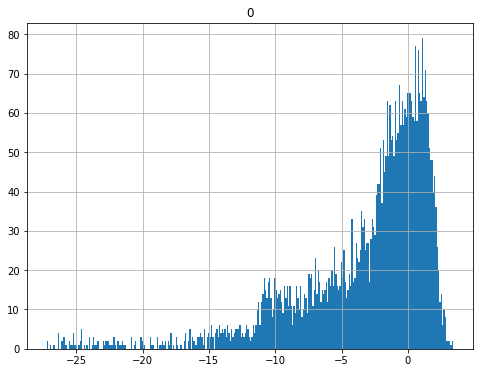

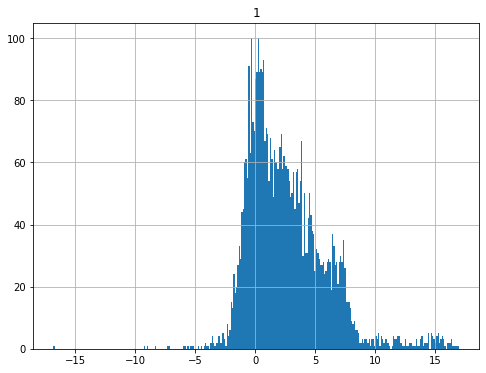

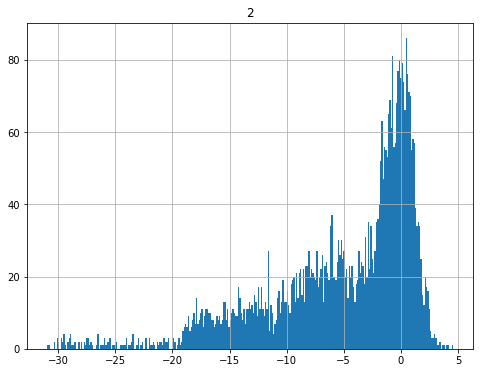

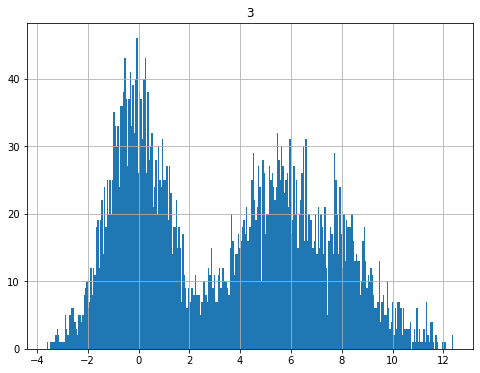

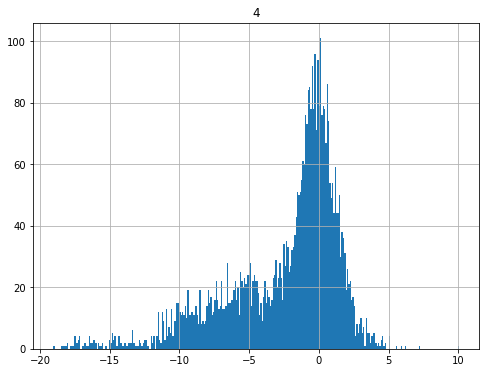

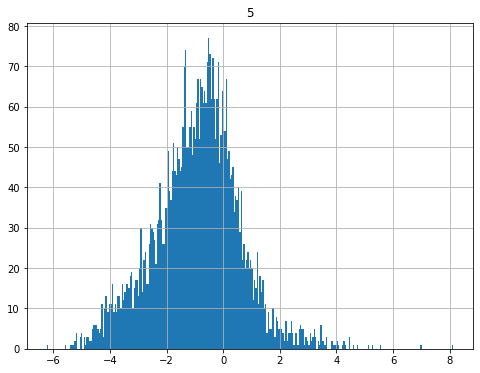

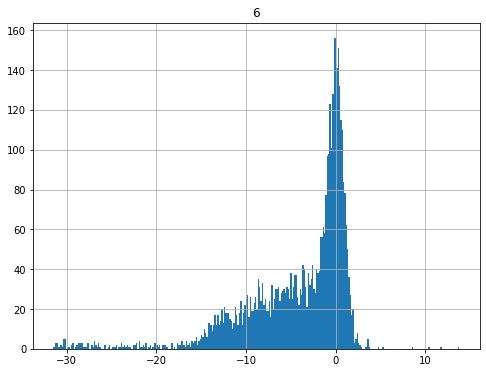

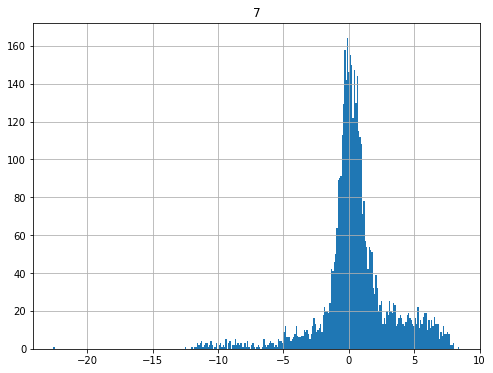

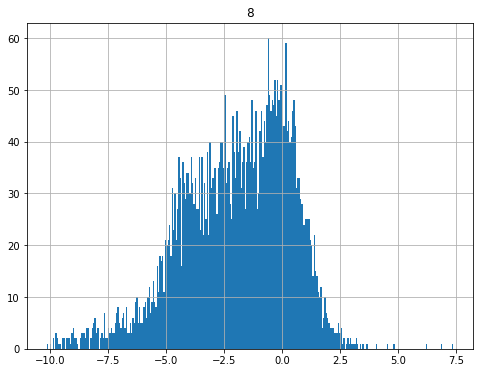

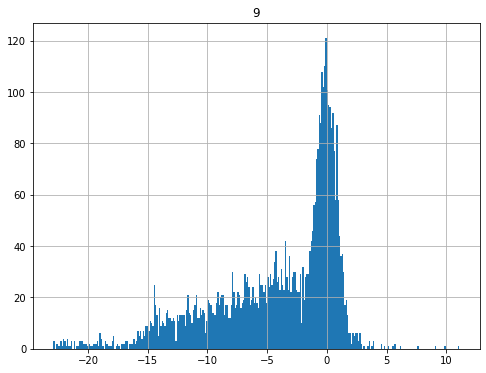

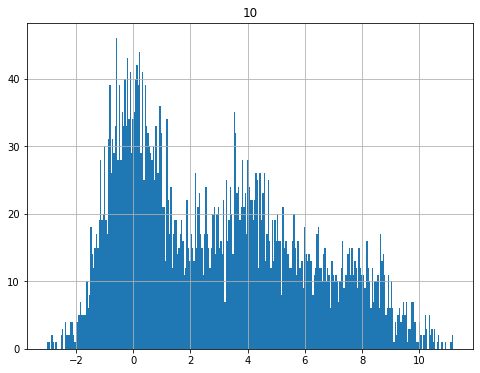

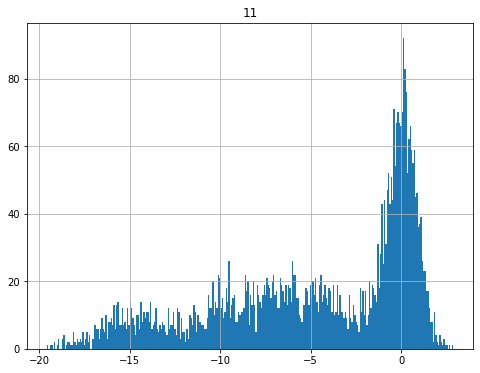

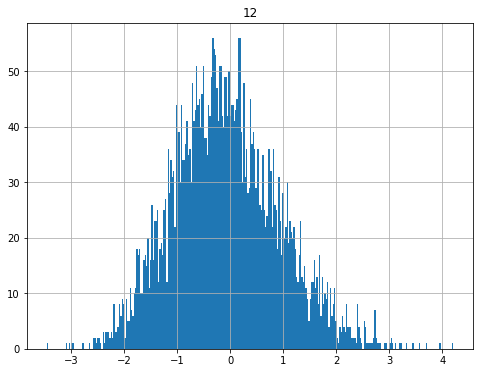

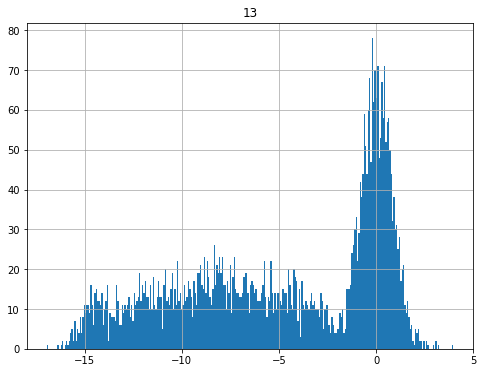

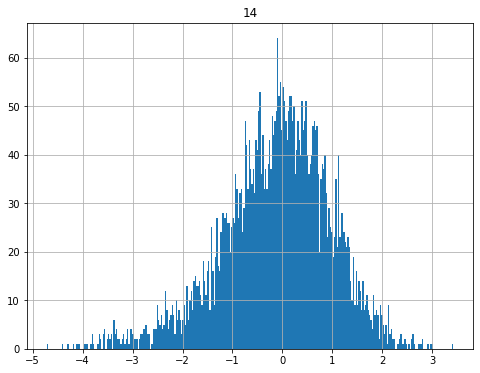

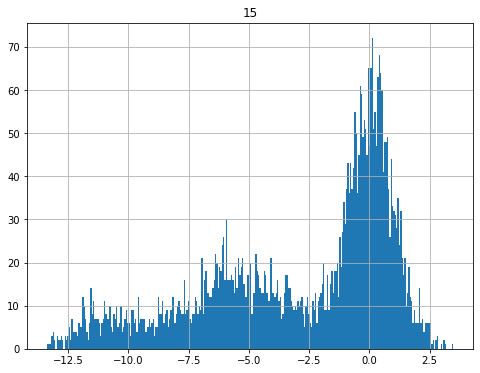

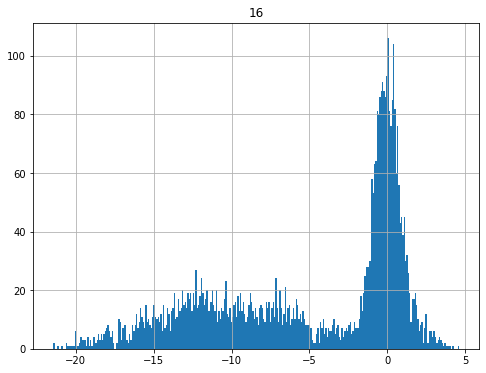

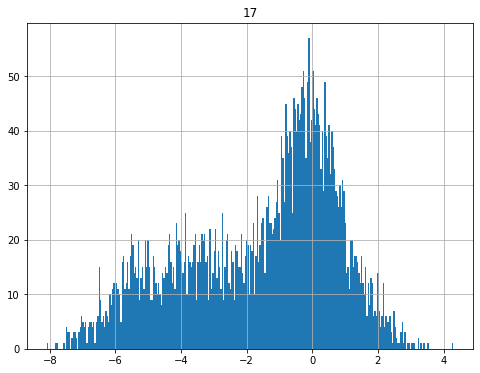

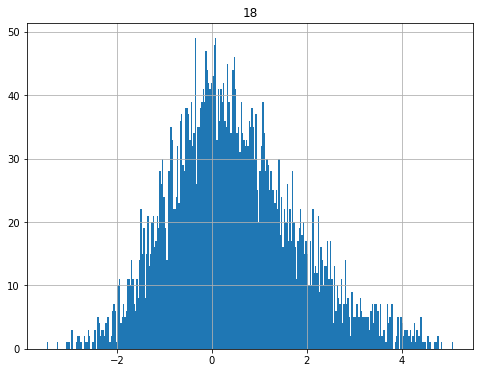

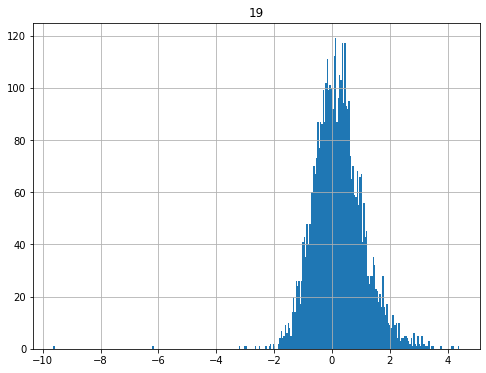

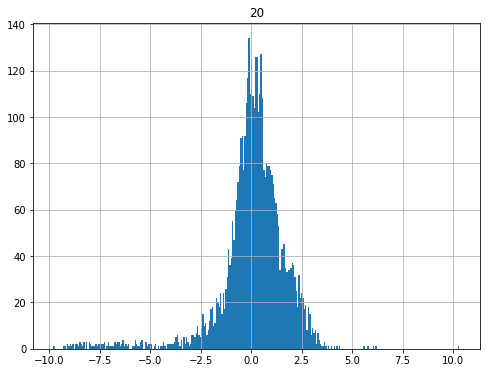

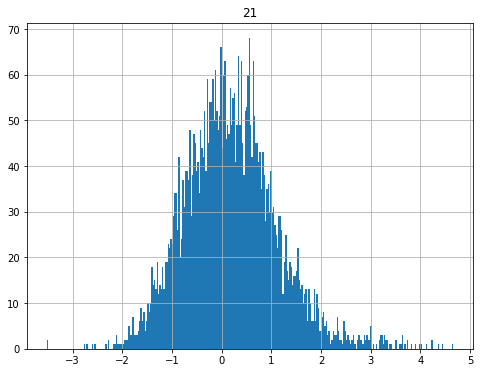

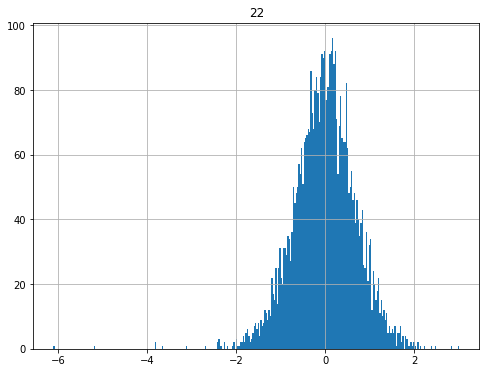

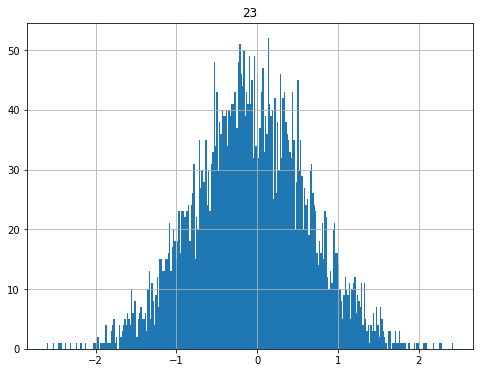

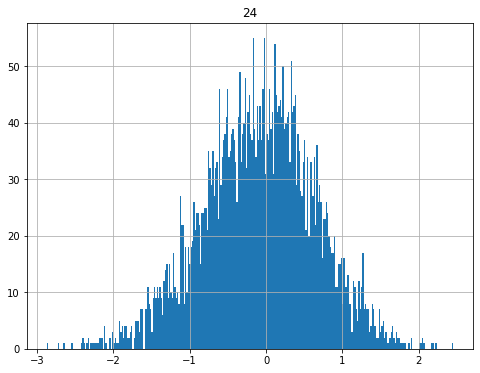

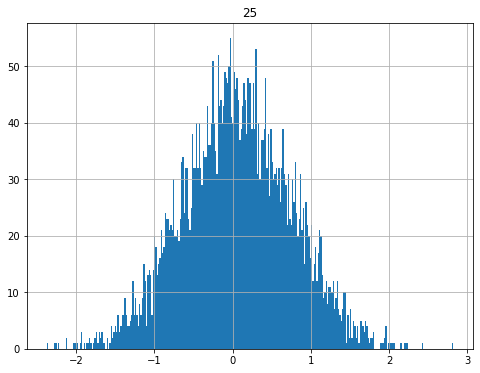

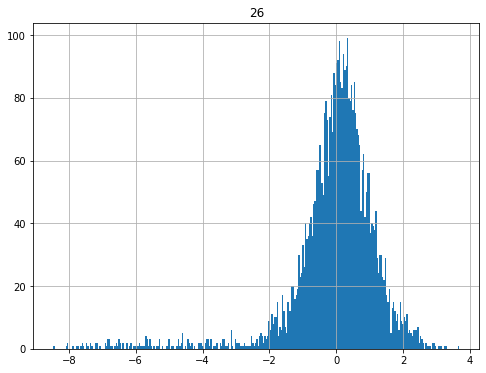

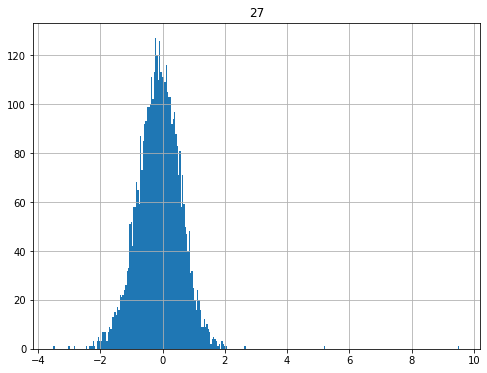

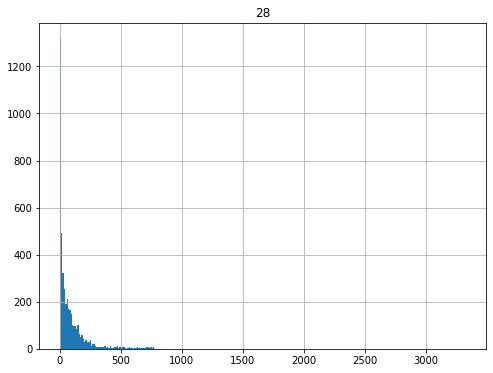

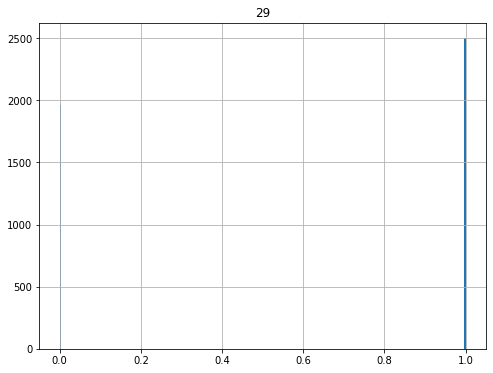

In [23]:
for i in list(df_gen):
    df_gen.hist(column=[i],bins=300, figsize=(8,6))

- **we can see that that distribution is maintained after new data generation**

# XGBoost

In [24]:
model_1 = XGBClassifier(n_estimators=100,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      subsample=0.5,         
                      colsample_bytree=0.5,  
                      scale_pos_weight=1,
                      max_depth=3,
                      random_state=38)

In [25]:
model_1.fit(df_gen.drop(columns=[29]),df_gen[29])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=38, ...)

In [26]:
# filename = 'model_1.sav'
# pickle.dump(model_1, open(filename, 'wb'))

In [27]:
y_pred1 = model_1.predict(pd.DataFrame(data.drop(columns=['Target']).to_numpy()))

m1 = confusion_matrix(data['Target'], y_pred1)
print(m1)

[[979   1]
 [  0  20]]


In [28]:
print('precision =',m1[0][0]/(m1[0][0]+m1[0][1]))
print('recall = ',m1[0][0]/(m1[0][0]+m1[1][0]))

precision = 0.9989795918367347
recall =  1.0


# Submission

In [29]:
x = pd.read_csv('PS1C_test.csv')
x.drop(columns=['Index'], inplace = True)

In [30]:
y_pred1 = model_1.predict(pd.DataFrame(x.to_numpy()))

In [31]:
index = [i for i in range(1,len(y_pred1)+1)]

In [32]:
df = pd.DataFrame({'Index': index, 'Target': y_pred1})

In [33]:
df.to_csv("sub_C.csv",index=False)

$$
\%------------------\%
$$